In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

import gym
import numpy as np
import ptan

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.nn.utils as nn_utils

import collections

sns.set_style('darkgrid')

## Solving the System of Equations

$\ddot{r} = - g$

### System of Equations

$y_0 = r$

$y_1 = \dot{r}$

---


$\dot{y}_0 = y_1$

$\dot{y}_1 =  -g$

## Natural Units

$g = 9.8 \ m/s^2 = 1 \ ln/tn^2$

In [63]:
class UniformGravity(gym.Env):
    metadata = {'render.modes': ['human']}
    
    # dt_s -- is the time step in seconds.
    def __init__(self, g = 9.8,  dt = 1.0, target_r = 2.0, 
                 record_history = True, record_rate = 100):
        
        super(UniformGravity, self).__init__()
        self.record_rate = record_rate
        self.max_thrust = 1.05
    
        # Actions
        self.action_space = gym.spaces.Box(low=np.array([-self.max_thrust]), 
                                           high=np.array([self.max_thrust]), 
                                           dtype=np.float32)
        
        # Obs (r,rdot)
        self.observation_space = gym.spaces.Box(low=np.array([0,0]), 
                                                high=np.array([5,10]), 
                                                dtype=np.float32)
        
        self.record_history = record_history
        
        # setting the target altitude in natural units
        self.target_r = target_r
        self.dt = dt
        self.g = 1.0
        self.max_time = 100.
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.steps = 0
        
        # Translational Coordinates
        self.r = 0.0
        self.r_dot = 0.0
        self.r_double_dot = 0.0

        self.elapsed_time = 0.0 # elapsed sim time in seconds
        
        # initialize the history array
        if self.record_history:
            self.trajectory = np.array([[self.r,self.r_dot, 1.0]])
        
        obs = np.array([self.r,self.r_dot])
        
        return obs
    
    # continous actions = (mean thrust, mean counter clockwise rotation thrust)
    def step(self, action):
        
        # actions segragation
        thrust = np.clip(action[0], -self.max_thrust, self.max_thrust)

        # Execute one time step within the environment using RK4
        self.elapsed_time += self.dt

        # integrate
        y0_k1 = self.r_dot
        y1_k1 = -self.g + thrust
        
        y0_k2 = (self.r_dot + y1_k1*self.dt/2)
        y1_k2 = -self.g + thrust
         
        y0_k3 = (self.r_dot + y1_k2*self.dt/2)
        y1_k3 = -self.g + thrust
          
        y0_k4 = (self.r_dot + y1_k3*self.dt)
        y1_k4 = -self.g + thrust

        # Update 
        self.r = self.r + self.dt/6*(y0_k1 + 2*y0_k2 + 2*y0_k3 + y0_k4)
        self.r_dot = self.r_dot + self.dt/6*(y1_k1 + 2*y1_k2 + 2*y1_k3 + y0_k4)
        
        # prepare to output
        obs = np.array([self.r,self.r_dot])
        
        # If recording is enabled record the trajectory
        if (self.record_history) and (self.steps % self.record_rate == 0):
            self.trajectory = np.append(self.trajectory,[[self.r,self.r_dot, thrust]],axis=0)
        
        # reward 1 for every step not done, encouraging staying above ground
        # plus a penalty for every step not near the target altitude
        reward = (self.dt - self.dt*np.abs(self.r - self.target_r) - self.dt*np.abs(self.r_dot))
        
        # set if at the terminal state
        done = False
        
        # test for terminal state
        if (self.r <= 0.0):
            reward = -self.elapsed_time
            done = True
        
        if (self.r >= 10*self.target_r):
            reward = -2*self.elapsed_time
            done = True
        
        if (self.elapsed_time > self.max_time):
            done = True
        
        return (obs, reward, done, {})
    
    def render(self, size=5, sample_traj_rate = 1):
        pass

## Example Policy

$J = {\rm min}_\kappa \ (\int_0^T\int_0^t (-g + \kappa (r(t', \kappa) - 1)) dt' dt - h)^2 +  (\int_0^T (-g + \kappa (r(t',\kappa) - 1)) dt')^2$

In [64]:
test_env = UniformGravity(dt = 0.1, target_r = 1.0, record_history = True)

In [65]:
s = test_env.reset()

while True:
    a = [-2.0*(s[0]-1) - 0.8*(s[1])]
        
    s, r, d, _ = test_env.step(a)

    if d == True:
        break

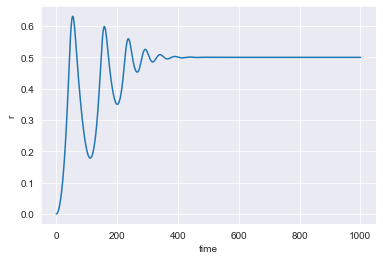

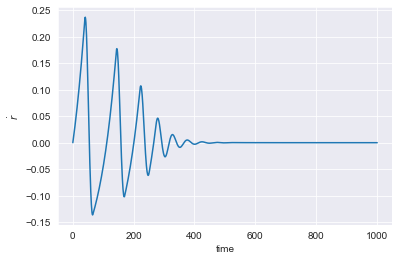

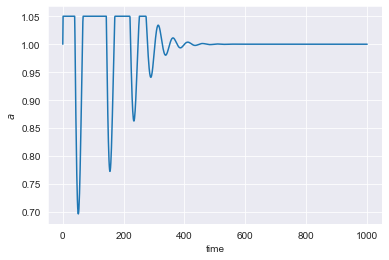

In [66]:
plt.plot(test_env.trajectory[:,0])
plt.ylabel('r')
plt.xlabel('time')
plt.show();

plt.plot(test_env.trajectory[:,1])
plt.ylabel('$\dot{r}$')
plt.xlabel('time')
plt.show();

plt.plot(test_env.trajectory[:,2])
plt.ylabel('$a$')
plt.xlabel('time')
plt.show();

In [67]:
def calc_logprob(mu_v, var_v, actions_v):
    p1 = - ((mu_v - actions_v) ** 2) / (2*var_v.clamp(min=1e-3))
    p2 = - torch.log(torch.sqrt(2 * np.pi * var_v))
    return p1 + p2

In [68]:
HID_SIZE = 64

class ModelA2C(nn.Module):
    def __init__(self, obs_size, act_size):
        super(ModelA2C, self).__init__()

        self.mu = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, act_size)
        )

        self.var = self.mu = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, act_size)
        )

        self.value = self.mu = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, 1)
        )

    def forward(self, x):
        return self.mu(x), torch.abs(self.var(x)), self.value(x)
    
class Policy(nn.Module):
    def __init__(self, obs_size, act_size):
        super(Policy, self).__init__()

        self.mu = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, act_size)
        )

        self.var = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, act_size)
        )


    def forward(self, x):
        return self.mu(x), torch.abs(self.var(x))

In [73]:
class AgentA2C(ptan.agent.BaseAgent):
    def __init__(self, net, device="cpu"):
        self.net = net
        self.device = device

    def __call__(self, states):
        states_v = ptan.agent.float32_preprocessor(states)
        states_v = states_v.to(self.device)

        mu_v, var_v, _ = self.net(states_v)
        mu = mu_v.data.cpu().numpy()
        sigma = torch.sqrt(var_v).data.cpu().numpy()
        actions = np.random.normal(mu, sigma)
        return actions
    
class AgentPolicy(ptan.agent.BaseAgent):
    def __init__(self, net, device="cpu"):
        self.net = net
        self.device = device

    def __call__(self, states):
        states_v = ptan.agent.float32_preprocessor(states)
        states_v = states_v.to(self.device)

        mu_v, var_v = self.net(states_v)
        
        mu = mu_v.data.cpu().numpy()
        sigma = torch.sqrt(var_v).data.cpu().numpy()
        actions = np.random.normal(mu, sigma)
        return actions

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = UniformGravity(dt = 0.1, target_r = 1.0, record_history = False)
test_env = UniformGravity(dt = 0.1, target_r = 1.0, record_history = True)

#policy_net = Policy(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
#policy_action = AgentPolicy(policy_net,device=device)

policy_net = ModelA2C(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
policy_action = AgentA2C(policy_net, device=device)

### Test Net Is Neutral (near zero means, near zero variances)

In [75]:
s = env.reset()
s_v = torch.FloatTensor([s]).to(device)
policy_net(s_v)

(tensor([[-0.2010]], grad_fn=<AddmmBackward>),
 tensor([[0.0736]], grad_fn=<AbsBackward>),
 tensor([[-0.2010]], grad_fn=<AddmmBackward>))

In [76]:
policy_action(s)

array([-0.20189066])

### Pretrain so that we have good initial settings (the mentor) of a linear proportional controller

In [93]:
batch_s = []
batch_a = []

s = env.reset()
while True:
    batch_s.append(s)
    desired_a = [-2.0*(s[0]-1) - 0.8*(s[1])]
    desired_a = np.clip(desired_a, a_min=-env.max_thrust, a_max = env.max_thrust)
    batch_a.append(desired_a)
    s, r, d, _ = env.step(a)
    if d:
        break
        

policy_net = ModelA2C(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr=0.005)

# this pumps the variance parameters so we start off with high exploration
s_v = torch.FloatTensor(batch_s).to(device)
a_v = torch.FloatTensor(batch_a).to(device)

var_target_v = torch.FloatTensor([1.0]).to(device)

idx = 0
while True:        
    optimizer.zero_grad()
    
    mu_v, var_v, _ = policy_net(s_v)
    var_loss_v = ((var_v - var_target_v)**2).mean()
    mu_loss_v = ((mu_v - a_v)**2).mean()
    
    loss_v = mu_loss_v + var_loss_v
    
    idx += 1
    if (idx % 100) == 0:
        print('loss: %.6f'%(loss_v.item()))
    
    loss_v.backward()
    optimizer.step()
    
    if loss_v.item() < 1e-4:
        break

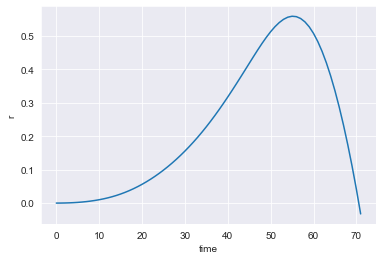

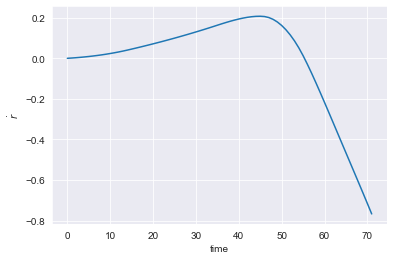

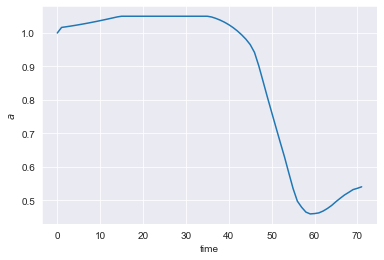

In [81]:
s = test_env.reset()

while True:
    s_v = torch.FloatTensor([s]).to(device)
    mu_v, var_v, _ = policy_net(s_v)
    a = mu_v.data.cpu().numpy()[0]
    s, r, d, _ = test_env.step(a)
    if d:
        break

plt.plot(test_env.trajectory[:,0])
plt.ylabel('r')
plt.xlabel('time')
plt.show();

plt.plot(test_env.trajectory[:,1])
plt.ylabel('$\dot{r}$')
plt.xlabel('time')
plt.show();

plt.plot(test_env.trajectory[:,2])
plt.ylabel('$a$')
plt.xlabel('time')
plt.show();

In [83]:
var_v

tensor([[0.8842]], grad_fn=<AbsBackward>)

In [84]:
def compute_discounted_rewards(epi_rewards):
    batch_R = []
    R = 0.0
    for r in reversed(epi_rewards):
        R = r + GAMMA*R
        batch_R.append(R)
    q = list(reversed(batch_R))
    return q

In [94]:
policy_action = AgentA2C(policy_net,device=device)

# Reset the optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

GAMMA = 0.99
BATCH_SIZE = 16
TRANSITIONS_BATCH_SIZE = 512
ENTROPY_BETA = 1e-5
CLIP_GRAD = 0.01

batch_states, batch_actions, batch_R = [],[],[]
batch_rewards = []

total_rewards = collections.deque(maxlen=100)

step_idx = 0
episode_length = 0
batch_episodes = 0
done_episodes = 0

state = env.reset()

while True:
    step_idx += 1
    episode_length += 1
    
    # select an action based on the current policy
    a = policy_action(state)
    new_state, r, done, _ = env.step(a)
    
    # store the experience
    batch_states.append(state)
    batch_actions.append(a)
    batch_rewards.append(r)

    if done:
        discounted_rewards = compute_discounted_rewards(batch_rewards)
        batch_R.extend(discounted_rewards)
        
        new_reward = np.sum(batch_rewards)
        total_rewards.append(new_reward)
        
        batch_rewards.clear()
        batch_episodes += 1
        done_episodes += 1
        
        state = env.reset()
        
        mean_rewards = np.mean(total_rewards)
        if done_episodes % 500 == 0:
            print("%d: reward: %6.6f, mean_100: %6.6f, episodes: %d, epi_length: %d" % (
                        step_idx, new_reward, mean_rewards, done_episodes, episode_length))
        
        if mean_rewards > 80:
            print('Solved in %d steps and in %d eps'%(step_idx, done_episodes))
            break
        
        episode_length = 0
    else:
        state = new_state

    if batch_episodes < BATCH_SIZE:
        continue
    
    r_idx = np.random.choice(range(len(batch_states)), np.min([len(batch_states), TRANSITIONS_BATCH_SIZE]))

    # done acquiring events, time to train
    batch_episodes = 0
    
    optimizer.zero_grad()
    
    batch_state_v = torch.FloatTensor(np.array(batch_states)[r_idx]).to(device)
    batch_actions_v = torch.LongTensor(np.array(batch_actions)[r_idx]).to(device)
    batch_R_v = torch.FloatTensor(np.array(batch_R)[r_idx]).to(device)
    
    mu_v, var_v, values_v = policy_net(batch_state_v)
    
    value_loss_v = F.mse_loss(values_v.squeeze(-1), batch_R_v)
    
    ent_v = -(torch.log(2*np.pi*var_v) + 1)/2
    entropy_loss_v =  ENTROPY_BETA*ent_v.mean()
    
    log_prob_v = (batch_R_v - values_v.detach())*calc_logprob(mu_v, var_v, batch_actions_v)
    loss_v = -(log_prob_v.mean())
    
    loss_v = loss_v - entropy_loss_v + value_loss_v #push entropy towards max uncertianty for all states as a threshold
    
    loss_v.backward()
    nn_utils.clip_grad_norm_(policy_net.parameters(), CLIP_GRAD)
    optimizer.step()
    
    batch_states.clear()
    batch_actions.clear()
    batch_R.clear()

1069: reward: -0.402258, mean_100: -0.221905, episodes: 500, epi_length: 4
1861: reward: -0.100000, mean_100: -0.137157, episodes: 1000, epi_length: 1
2528: reward: -0.100000, mean_100: -0.136180, episodes: 1500, epi_length: 1
3153: reward: -0.200213, mean_100: -0.127130, episodes: 2000, epi_length: 2
3788: reward: -0.100000, mean_100: -0.133146, episodes: 2500, epi_length: 1
4431: reward: -0.100000, mean_100: -0.127136, episodes: 3000, epi_length: 1
5071: reward: -0.100000, mean_100: -0.131148, episodes: 3500, epi_length: 1
5700: reward: -0.100000, mean_100: -0.131163, episodes: 4000, epi_length: 1
6332: reward: -0.100000, mean_100: -0.125110, episodes: 4500, epi_length: 1
6971: reward: -0.100000, mean_100: -0.128155, episodes: 5000, epi_length: 1
7597: reward: -0.200400, mean_100: -0.119079, episodes: 5500, epi_length: 2
8213: reward: -0.100000, mean_100: -0.130143, episodes: 6000, epi_length: 1
8830: reward: -0.200400, mean_100: -0.132165, episodes: 6500, epi_length: 2
9449: reward:

KeyboardInterrupt: 

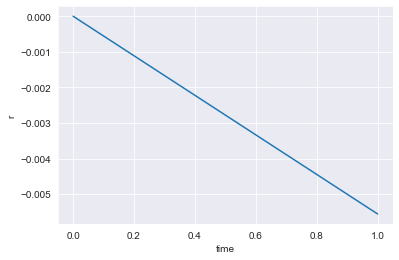

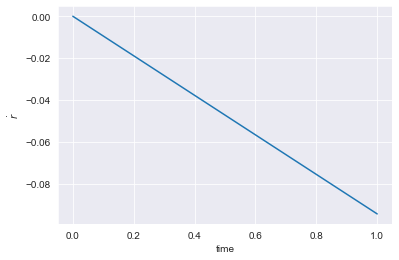

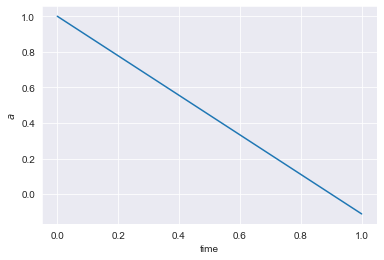

In [96]:
s = test_env.reset()

while True:
    s_v = torch.FloatTensor([s]).to(device)
    mu_v, var_v, _ = policy_net(s_v)
    a = mu_v.data.cpu().numpy()[0]
    s, r, d, _ = test_env.step(a)
    if d:
        break

plt.plot(test_env.trajectory[:,0])
plt.ylabel('r')
plt.xlabel('time')
plt.show();

plt.plot(test_env.trajectory[:,1])
plt.ylabel('$\dot{r}$')
plt.xlabel('time')
plt.show();

plt.plot(test_env.trajectory[:,2])
plt.ylabel('$a$')
plt.xlabel('time')
plt.show();